In [ ]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np

import time
import os
from os import listdir, rmdir, remove

import matplotlib as mpl
import matplotlib.pyplot as plt

import shutil

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 9)

# Etude 1 - Implementing a Custom Layer that Performs Layer Normalization

The build() method should define two trainable weights α and β, both of shape input_shape[-1:] and data type tf.float32. α should be initialized with 1s, and β with 0s. The call() method should compute the mean μ and standard deviation σ of each instance’s features. For this, you can use tf.nn.moments(inputs, axes=-1, keepdims=True), which returns the mean μ and the variance σ2 of all instances (compute the square root of the variance to get the standard deviation). Then the function should compute and return α⊗(X - μ)/(σ + ε) + β, where ⊗ represents itemwise multiplication (*) and ε is a smoothing term (small constant to avoid division by zero, e.g., 0.001).

In [ ]:
class MyLayerNormalization(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)        
        
    def build(self, input_shape):
        self.alpha = self.add_weight(name="alpha", shape=input_shape[-1],
            initializer="ones", dtype=tf.float32)
        self.beta = self.add_weight(name="alpha", shape=input_shape[-1],
            initializer="zeros", dtype=tf.float32)
        super().build(input_shape)
            
    def call(self, inputs, training=None):
        mean, variance = tf.nn.moments(inputs, axes=-1, keepdims=True)
        return tf.math.multiply(self.alpha, (inputs - mean)) / (tf.math.sqrt(variance) + 0.001) + self.beta       

Ensure that your custom layer produces the same (or very nearly the same) output as the keras.layers.LayerNormalization layer.

In [ ]:
test_data = tf.random.uniform([10, 5])

In [ ]:
layer_norm =  MyLayerNormalization() 
layer_norm(test_data)

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[ 1.5392866 , -0.20615184, -0.49183598,  0.5669377 , -1.4082355 ],
       [-0.8432497 ,  0.35843465, -0.37058932,  1.7737797 , -0.918375  ],
       [-1.3687534 ,  1.5947832 ,  0.37888616, -0.6351914 ,  0.03027499],
       [ 0.5043491 , -0.06117297, -1.6701286 ,  1.3722509 , -0.14529826],
       [ 1.2652061 , -0.77703696,  0.70517224,  0.28012502, -1.4734666 ],
       [ 1.0316886 , -0.04289917,  1.1250477 , -1.4693377 , -0.6444989 ],
       [ 0.5452232 , -1.3154587 ,  1.2975426 , -1.0086884 ,  0.48138145],
       [-0.5804006 ,  1.2968658 ,  0.7059076 , -1.5555379 ,  0.13316569],
       [-0.06075613,  1.6302836 , -0.5397083 , -1.3742083 ,  0.3443893 ],
       [-1.1955148 ,  0.42717287,  0.8529793 ,  1.103795  , -1.1884334 ]],
      dtype=float32)>

In [ ]:
layer_batch = tf.keras.layers.LayerNormalization()
layer_batch(test_data)

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[ 1.532338  , -0.20522149, -0.48961607,  0.5643783 , -1.401879  ],
       [-0.841351  ,  0.35762757, -0.36975488,  1.7697859 , -0.91630715],
       [-1.3650616 ,  1.5904819 ,  0.37786427, -0.63347816,  0.03019334],
       [ 0.50089455, -0.06075387, -1.6586887 ,  1.3628516 , -0.14430293],
       [ 1.2564201 , -0.7716411 ,  0.70027524,  0.2781797 , -1.4632345 ],
       [ 0.9974114 , -0.04147396,  1.0876687 , -1.4205201 , -0.6230859 ],
       [ 0.5431182 , -1.3103799 ,  1.292533  , -1.0047941 ,  0.4795229 ],
       [-0.577028  ,  1.2893293 ,  0.70180523, -1.5464987 ,  0.13239162],
       [-0.06050995,  1.623678  , -0.5375215 , -1.3686402 ,  0.3429939 ],
       [-1.1937196 ,  0.42653167,  0.8516988 ,  1.1021379 , -1.1866487 ]],
      dtype=float32)>

# Etude 2 - Implementing a Custom Traning Loop

Let's train a model using a custom training loop to tackle the Fashion MNIST dataset.

In [ ]:
EPOCHS_N = 25
BATCH_SIZE = 32

In [ ]:
(full_X_train, full_y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
X_train, X_valid = full_X_train[:50000] / 255., full_X_train[50000:] / 255.

In [ ]:
y_train, y_valid = full_y_train[:50000], full_y_train[50000:]

In [ ]:
tf.keras.backend.set_floatx('float64')

In [ ]:
inputs = keras.layers.Input(shape=(28,28))
flatten = keras.layers.Flatten()(inputs)
ln_1 = keras.layers.BatchNormalization()(flatten)
hidden_1 = keras.layers.Dense(500, activation='relu')(ln_1)
ln_2 = keras.layers.BatchNormalization()(hidden_1)
hidden_2 = keras.layers.Dense(500, activation='relu')(ln_2)
outputs = keras.layers.Dense(10, activation='softmax')(hidden_2)
model = keras.models.Model(inputs=inputs, outputs=outputs)

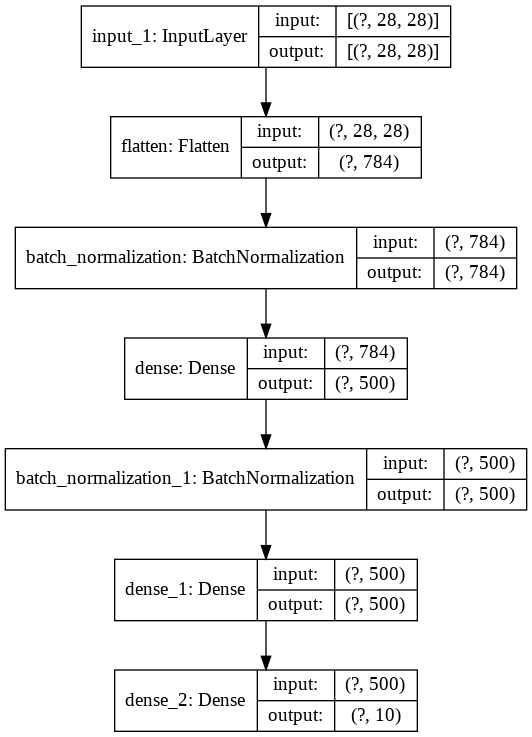

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Nadam",
              metrics=["accuracy"])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCHS_N, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2217 - accuracy: 0.9332 - val_loss: 0.1407 - val_accuracy: 0.9621
Epoch 2/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1121 - accuracy: 0.9653 - val_loss: 0.1032 - val_accuracy: 0.9721
Epoch 3/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0820 - accuracy: 0.9741 - val_loss: 0.1105 - val_accuracy: 0.9729
Epoch 4/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0688 - accuracy: 0.9777 - val_loss: 0.1333 - val_accuracy: 0.9686
Epoch 5/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0531 - accuracy: 0.9833 - val_loss: 0.1064 - val_accuracy: 0.9766
Epoch 6/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0490 - accuracy: 0.9844 - val_loss: 0.0968 - val_accuracy: 0.9776
Epoch 7/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0432 - accuracy: 0.9864 - val_loss: 0.1162 - val_accuracy:

In [ ]:
model.evaluate(X_test, y_test, verbose=2)

313/313 - 1s - loss: 244.0947 - accuracy: 0.8670


[244.0947002532959, 0.867]

Display the epoch, iteration, mean training loss, and mean accuracy over each epoch (updated at each iteration), as well as the validation loss and accuracy at the end of each epoch.

In [ ]:
n_steps = len(X_train) // BATCH_SIZE
optimizer = keras.optimizers.Nadam()
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
mean_accuracy = keras.metrics.Mean()
metric = keras.metrics.SparseCategoricalAccuracy()

In [ ]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [ ]:
for epoch in range(1, EPOCHS_N + 1):
    print(f"Epoch {epoch} / {EPOCHS_N}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            accuracy = tf.reduce_mean(metric(y_batch, y_pred))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        mean_loss(loss)               
        mean_accuracy(accuracy)        

    y_pred_valid = model(X_valid)
    val_loss = tf.reduce_mean(loss_fn(y_valid, y_pred_valid))

    print(f" Mean accuracy: {mean_accuracy(accuracy)}")
    print(f" Mean training loss: {mean_loss(loss)}")
    print(f" Validation loss: {val_loss}")
    print(f" Validation accuracy: {model.evaluate(X_valid, y_valid, verbose=0)[1]}")
    metric.reset_states()        

Epoch 1 / 25
 Mean accuracy: 0.9911152392412367
 Mean training loss: 0.03573256717343536
 Validation loss: 0.11568087019982792
 Validation accuracy: 0.9781
Epoch 2 / 25
 Mean accuracy: 0.9906899555883787
 Mean training loss: 0.03398066446157456
 Validation loss: 0.11036933768336812
 Validation accuracy: 0.9798
Epoch 3 / 25
 Mean accuracy: 0.9913702040834923
 Mean training loss: 0.03244015332218455
 Validation loss: 0.11208646699643068
 Validation accuracy: 0.9797
Epoch 4 / 25
 Mean accuracy: 0.9918427578047847
 Mean training loss: 0.030228153166584244
 Validation loss: 0.16078481675863043
 Validation accuracy: 0.9738
Epoch 5 / 25
 Mean accuracy: 0.9920359784069662
 Mean training loss: 0.028439872811267503
 Validation loss: 0.13223949681642044
 Validation accuracy: 0.9756
Epoch 6 / 25
 Mean accuracy: 0.992391255198087
 Mean training loss: 0.027683649988149
 Validation loss: 0.1358723352772705
 Validation accuracy: 0.9795
Epoch 7 / 25
 Mean accuracy: 0.9927018082393336
 Mean training los

Try using a different optimizer with a different learning rate for the upper layers and the lower layers.

In [ ]:
keras.backend.clear_session()

In [ ]:
# we should use flatten(); otherwise, we get list of lists
# we use condition because some layers have not trainable variables
lower_layers_params = tf.nest.flatten([layer.trainable_variables for layer in model.layers[:4] if layer.trainable_variables])
upper_layers_params = tf.nest.flatten([layer.trainable_variables for layer in model.layers[4:] if layer.trainable_variables])

In [ ]:
optimizer1 = keras.optimizers.Nadam(learning_rate=0.00001)
optimizer2 = keras.optimizers.Nadam(learning_rate=0.0001)

In [ ]:
for epoch in range(1, EPOCHS_N + 1):
    print(f"Epoch {epoch} / {EPOCHS_N}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            accuracy = tf.reduce_mean(metric(y_batch, y_pred))
        
        gradients = tape.gradient(loss, lower_layers_params + upper_layers_params)
                
        # here we split the gradients into lower and upper layer params
        gradients1 = gradients[:len(lower_layers_params)]
        gradients2 = gradients[len(lower_layers_params):]
        
        # apply own optimizer to each layer
        optimizer1.apply_gradients(zip(gradients1, lower_layers_params))
        optimizer2.apply_gradients(zip(gradients2, upper_layers_params))       
        
        mean_loss(loss)               
        mean_accuracy(accuracy)        

    y_pred_valid = model(X_valid)
    val_loss = tf.reduce_mean(loss_fn(y_valid, y_pred_valid))

    print(f" Mean accuracy: {mean_accuracy(accuracy)}")
    print(f" Mean training loss: {mean_loss(loss)}")
    print(f" Validation loss: {val_loss}")
    print(f" Validation accuracy: {model.evaluate(X_valid, y_valid, verbose=0)[1]}")
    metric.reset_states()

Epoch 1 / 25
 Mean accuracy: 0.9954586176391972
 Mean training loss: 0.019650367005011975
 Validation loss: 0.1737420589052784
 Validation accuracy: 0.9813
Epoch 2 / 25
 Mean accuracy: 0.9956082560636428
 Mean training loss: 0.018975038741266225
 Validation loss: 0.16992237828203366
 Validation accuracy: 0.9819
Epoch 3 / 25
 Mean accuracy: 0.995750532637636
 Mean training loss: 0.018351238201238334
 Validation loss: 0.16777939034517203
 Validation accuracy: 0.9822
Epoch 4 / 25
 Mean accuracy: 0.9958931910714915
 Mean training loss: 0.01775691267282441
 Validation loss: 0.16727341461506498
 Validation accuracy: 0.9819
Epoch 5 / 25
 Mean accuracy: 0.9960286889329943
 Mean training loss: 0.017188515214484994
 Validation loss: 0.16703051386295584
 Validation accuracy: 0.9822
Epoch 6 / 25
 Mean accuracy: 0.996155763194951
 Mean training loss: 0.01666588607864621
 Validation loss: 0.16678245656134483
 Validation accuracy: 0.9824
Epoch 7 / 25
 Mean accuracy: 0.996272373675439
 Mean training l

In [ ]:
model.evaluate(X_test, y_test, verbose=2)

313/313 - 1s - loss: 1566.0240 - accuracy: 0.8857


[1566.0239802429198, 0.8857]